# Import

In [1]:
import torch
import torchvision
from torchvision import transforms
import torch.nn as nn
import time
import copy
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, TensorDataset, DataLoader, random_split, SubsetRandomSampler
import torchvision.models as models
from torch.utils.tensorboard import SummaryWriter
import pytorch_lightning as pl
from pytorch_lightning import Trainer
import os
import re
import shutil
import sys
import ipywidgets
from scipy import stats
from os import listdir
from textwrap import wrap

#from pytorch_lightning.callbacks import ModelCheckpoint

In [2]:
AVAIL_GPUS = torch.cuda.device_count()
print(AVAIL_GPUS)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

1


In [ ]:
# Creat a file of detailed information of outputs

import csv 
# x = []
# y= []


# for idx in range(937):
#     x1, y1 = copperDataset.__getitem__(idx)
#     x.append(np.array(x1.reshape(1,len(x1))))
#     y.append(np.array(y1.reshape(1,len(y1))))
# y = np.asmatrix(np.vstack(y))
output_info = []
rows = []
Details = ['filename', 'row_index', 'col_index', 'mean', 'std', 'min', 'max', 'most frequncies']

y_mean = y.mean(axis=0)
y_std = y.std(axis=0)
y_min = y.min(axis=0)
y_max = y.max(axis=0)
output_idx = copperDataset.get_output_index(1)
bins = bins = np.arange(y.min(), y.max() + 2)
n = 5

for i in range(y.shape[1]):
    output_info.append(output_idx_raw[i][0])
    output_info.append(output_idx_raw[i][1])
    output_info.append(output_idx_raw[i][2])
    output_info.append(y_mean[0, i])
    output_info.append(y_std[0, i])
    output_info.append(y_min[0, i])
    output_info.append(y_max[0, i])
    rows.append(output_info)
    h, _  = np.histogram(y[:,i], bins, density = False)
    sorted_index_array = np.argsort(h)[::-1]
    sorted_array = h[sorted_index_array]
    rslt = sorted_array[0 : n ]
    output_info.append(rslt)
    output_info = []
    
with open('output_info.csv', 'w') as f: 
    write = csv.writer(f) 
    write.writerow(Details) 
    write.writerows(rows)

In [ ]:
# utility function for converting csv to xslx:

#Convert input .csv files (annual_growth) to .xlsx
# dir is input directory
dir = 'COPPER5_CapCost_CTax_PopGrowth_all_False/inputs'
CSV_Files = [file for file in listdir(dir) if file.endswith('.csv') and file.startswith('annual_growth')]
for i in CSV_Files:
    path = os.path.join(dir, i)
    filename = os. path. splitext(i)[0]
    info = pd.read_csv(path)
    info.to_excel ('%s/%s.xlsx' %(dir,filename), index = None, header=True)
    # os.remove(path)

In [4]:
# Creat a dataset object

in_dir = 'COPPER5_CapCost_CTax_PopGrowth_all_False/inputs'
out_dir = 'COPPER5_CapCost_CTax_PopGrowth_all_False/outputs'
copperDataset = COPPERDataset(in_dir,out_dir)

In [5]:
input_idx_raw = copperDataset.get_input_index(0)
output_idx_raw = copperDataset.get_output_index(0)
for i in range(len(output_idx_raw)):
    output_idx_raw[i].append(i)
    
for i in range(len(input_idx_raw)):
    input_idx_raw[i].append(i)

In [6]:
#Read all data on memory

x = []
y = []

for idx in range(1000):
    x1, y1 = copperDataset.__getitem__(idx)
    x.append(np.array(x1.reshape(1,len(x1))))
    y.append(np.array(y1.reshape(1,len(y1))))

x_raw = np.array(np.vstack(x))
y_raw = np.array(np.vstack(y))

In [7]:
# Remove Nan
x_p, input_p_idx = preprocess(x_raw, input_idx_raw)
y_p, output_p_idx = preprocess(y_raw, output_idx_raw)

In [8]:
# Normalization and Remove Outliers 

x_s, input_s_idx  = stdCleanup(x_p, input_p_idx)
y_s, output_s_idx = stdCleanup(y_p, output_p_idx)

x,mean_x,std_x = normalize(x_s)
y,mean_y,std_y = normalize(y_s)

# print(y_s.std(axis=0))

In [ ]:
print(x.shape)
print(y.shape)
plot_hist(x,input_s_idx,'input_hist_norm')
plot_hist(y,output_s_idx,'output_hist_norm')

In [9]:
ignore_index = [51,54,60,65,68,86,87,91,94,112,118,119,134,168,171,182,185,203,204,208,211,229,235,236,285,295,299,325,327,328,347,349,351,352,353,354,368,384,385,386,393,394,395,407]
# ignore_index = []
tmp_index = [tmp_list[3] for tmp_list in output_s_idx]
indices = np.where(np.in1d(tmp_index,ignore_index))[0]
y_train_np = np.delete(y,indices,axis=1)
y_train_idx = output_s_idx.copy()
for i in sorted(indices, reverse=True):
    del y_train_idx[i]

x_train_np = x
x_train_idx = input_s_idx.copy()
mean_y_np = np.delete(mean_y,indices)
std_y_np = np.delete(std_y,indices)

In [21]:
# Write mean and std of data in a file 

df = pd.DataFrame(mean_x, columns = ['mean_x'])
df = pd.concat([df, pd.DataFrame(std_x, columns = ['std_x'])], axis = 1)
df = pd.concat([df, pd.DataFrame(mean_y_np, columns = ['mean_y'])], axis = 1)
df = pd.concat([df, pd.DataFrame(std_y_np, columns = ['std_y'])], axis = 1)
df.to_excel('Mean_std.xlsx',index=False)

In [10]:
x_train = torch.tensor(x_train_np).float()
y_train = torch.tensor(y_train_np).float()

print(x_train.shape)
print(y_train.shape)

torch.Size([1000, 38])
torch.Size([1000, 57])


##### Initialize 

In [31]:
dim_input,dim_output = x_train.shape[1],y_train.shape[1]
print(dim_input)
print(dim_output)
num_epoch = 1000
batch_size = 128
lr = 1e-3

38
57


In [53]:
# Split dataset to train, validation, and test sets

test_ratio = 0.3
valid_ratio = 0.1
X_polt = x_train
Y_polt = y_train

x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=test_ratio, random_state=1, shuffle=True)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=valid_ratio, random_state=1, shuffle=True)
train_dataset = TensorDataset(x_train,y_train)
valid_dataset = TensorDataset(x_valid,y_valid)
test_dataset = TensorDataset(x_test,y_test)

In [12]:
# Load saved model 
layers = [[block_1d,128,nn.ReLU,0]]
dim_output = 57
dim_input = 38
num_blocks = 8

for i in range(num_blocks):
    layers.append([res_block_1d,128,nn.ReLU,0.2])  
 
new_model = resnet.load_from_checkpoint("ModelAp29.ckpt", in_dim = dim_input, out_dim = dim_output, layers = layers )

In [ ]:
y = new_model (x_test)
print(y[0])

In [63]:
import matplotlib.pyplot as plt
from importlib import reload
plt=reload(plt)

In [64]:
csfont = {'fontname':'Comic Sans MS'}
hfont = {'fontname':'Helvetica'}

# plt.title('title',**csfont)
# plt.xlabel('xlabel', **hfont)
# plt.show()

In [68]:
from matplotlib import rc
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('font',**{'family':'serif','serif':['Cambria']})
rc('text', usetex=True)

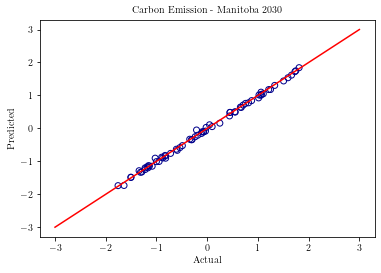

In [84]:
i = 6
s = 3
predictions = new_model (x_test)
predictions = predictions.detach()
# y_test = y_test.detach().numpy
# print(predictions.size)
x, y = [-s, s],[-s, s]
plt.scatter(y_test[:,i], predictions[:,i], marker='o',  facecolors='none', edgecolors= "darkblue")
plt.plot(x, y, c='red') # Perfect prediction line
# plt.title("\n".join(wrap(str(y_train_idx[i]), 30)), fontsize=15)
plt.title('Carbon Emission - Manitoba 2030', fontsize=10)
plt.xlabel('Actual', fontdict=None, labelpad=None)
# xlabel('Actual', fontsize=10)
plt.ylabel('Predicted', fontsize=10)
plt.savefig("Regression_Carbon Emission - Manitoba 2030", dpi=200)

In [ ]:
# Launch TensorBoard

%reload_ext tensorboard
%tensorboard --logdir='./COPPER_runs/COPPER938/COPPER938_Linear_1000_128_/version_45' --host 0.0.0.0

In [ ]:
!kill 29969